# Task 1: Introduction

---

For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](images/regression.png)

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

## 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
#import logging
#logger = tf.get_logger()

%matplotlib inline
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#logger.setLevel(logging.ERROR)
#tf.logging.set_verbosity(tf.logging.WARN)
print('Libraries imported.')

Libraries imported.


# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [19]:
df = pd.read_csv('data.csv', names = column_names) 
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [20]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [21]:
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [22]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.350088))

14263


# Task 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [23]:
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [24]:
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [25]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


# Task 5: Create the Model

## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [31]:
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adadelta'
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 10)                70        
_________________________________________________________________
dense_21 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1800,
    callbacks = [early_stopping]
)

Epoch 1/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9796 - val_loss: 0.8518
Epoch 2/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9790 - val_loss: 0.8513
Epoch 3/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9785 - val_loss: 0.8507
Epoch 4/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9779 - val_loss: 0.8502
Epoch 5/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9774 - val_loss: 0.8497
Epoch 6/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9769 - val_loss: 0.8492
Epoch 7/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9764 - val_loss: 0.8487
Epoch 8/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9759 - val_loss: 0.8482
Epoch 9/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9754 - val_loss: 0.8477
Epoch 10/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.974

149/149 [==============================] - 0s 1ms/step - loss: 0.9383 - val_loss: 0.8127
Epoch 81/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9378 - val_loss: 0.8123
Epoch 82/1800
149/149 [==============================] - 0s 998us/step - loss: 0.9373 - val_loss: 0.8118
Epoch 83/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9368 - val_loss: 0.8113
Epoch 84/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9362 - val_loss: 0.8108
Epoch 85/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9357 - val_loss: 0.8103
Epoch 86/1800
149/149 [==============================] - 0s 999us/step - loss: 0.9351 - val_loss: 0.8098
Epoch 87/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9346 - val_loss: 0.8094
Epoch 88/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9341 - val_loss: 0.8089
Epoch 89/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.9335

149/149 [==============================] - 0s 1ms/step - loss: 0.8894 - val_loss: 0.7711
Epoch 160/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.8886 - val_loss: 0.7705
Epoch 161/1800
149/149 [==============================] - 0s 979us/step - loss: 0.8878 - val_loss: 0.7698
Epoch 162/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.8870 - val_loss: 0.7691
Epoch 163/1800
149/149 [==============================] - 0s 995us/step - loss: 0.8863 - val_loss: 0.7684
Epoch 164/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.8855 - val_loss: 0.7678
Epoch 165/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.8847 - val_loss: 0.7671
Epoch 166/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.8839 - val_loss: 0.7664
Epoch 167/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.8830 - val_loss: 0.7657
Epoch 168/1800
149/149 [==============================] - 0s 1ms/step - los

149/149 [==============================] - 0s 994us/step - loss: 0.8128 - val_loss: 0.7096
Epoch 238/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.8117 - val_loss: 0.7087
Epoch 239/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.8106 - val_loss: 0.7078
Epoch 240/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.8094 - val_loss: 0.7069
Epoch 241/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.8083 - val_loss: 0.7060
Epoch 242/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.8072 - val_loss: 0.7051
Epoch 243/1800
149/149 [==============================] - 0s 990us/step - loss: 0.8061 - val_loss: 0.7042
Epoch 244/1800
149/149 [==============================] - 0s 981us/step - loss: 0.8050 - val_loss: 0.7033
Epoch 245/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.8039 - val_loss: 0.7024
Epoch 246/1800
149/149 [==============================] - 0s 982us/step -

149/149 [==============================] - 0s 1ms/step - loss: 0.7282 - val_loss: 0.6426
Epoch 316/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.7271 - val_loss: 0.6417
Epoch 317/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.7260 - val_loss: 0.6409
Epoch 318/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.7249 - val_loss: 0.6400
Epoch 319/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.7239 - val_loss: 0.6392
Epoch 320/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.7228 - val_loss: 0.6383
Epoch 321/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.7218 - val_loss: 0.6375
Epoch 322/1800
149/149 [==============================] - 0s 997us/step - loss: 0.7207 - val_loss: 0.6367
Epoch 323/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.7197 - val_loss: 0.6359
Epoch 324/1800
149/149 [==============================] - 0s 1ms/step - loss:

Epoch 394/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.6463 - val_loss: 0.5790
Epoch 395/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.6453 - val_loss: 0.5782
Epoch 396/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.6443 - val_loss: 0.5774
Epoch 397/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.6432 - val_loss: 0.5766
Epoch 398/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.6422 - val_loss: 0.5758
Epoch 399/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.6412 - val_loss: 0.5751
Epoch 400/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.6402 - val_loss: 0.5743
Epoch 401/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.6392 - val_loss: 0.5735
Epoch 402/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.6382 - val_loss: 0.5727
Epoch 403/1800
149/149 [==============================] - 0s 1ms

149/149 [==============================] - 0s 1ms/step - loss: 0.5695 - val_loss: 0.5186
Epoch 473/1800
149/149 [==============================] - 0s 992us/step - loss: 0.5686 - val_loss: 0.5179
Epoch 474/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.5676 - val_loss: 0.5171
Epoch 475/1800
149/149 [==============================] - 0s 967us/step - loss: 0.5666 - val_loss: 0.5164
Epoch 476/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.5657 - val_loss: 0.5156
Epoch 477/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.5647 - val_loss: 0.5149
Epoch 478/1800
149/149 [==============================] - 0s 993us/step - loss: 0.5638 - val_loss: 0.5141
Epoch 479/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.5628 - val_loss: 0.5134
Epoch 480/1800
149/149 [==============================] - 0s 990us/step - loss: 0.5619 - val_loss: 0.5127
Epoch 481/1800
149/149 [==============================] - 0s 1ms/step -

Epoch 551/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.4967 - val_loss: 0.4618
Epoch 552/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.4958 - val_loss: 0.4611
Epoch 553/1800
149/149 [==============================] - 0s 990us/step - loss: 0.4949 - val_loss: 0.4604
Epoch 554/1800
149/149 [==============================] - 0s 986us/step - loss: 0.4940 - val_loss: 0.4597
Epoch 555/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.4931 - val_loss: 0.4590
Epoch 556/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.4922 - val_loss: 0.4583
Epoch 557/1800
149/149 [==============================] - 0s 990us/step - loss: 0.4913 - val_loss: 0.4576
Epoch 558/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.4904 - val_loss: 0.4569
Epoch 559/1800
149/149 [==============================] - 0s 998us/step - loss: 0.4896 - val_loss: 0.4562
Epoch 560/1800
149/149 [==============================] 

149/149 [==============================] - 0s 1ms/step - loss: 0.4299 - val_loss: 0.4093
Epoch 630/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.4290 - val_loss: 0.4087
Epoch 631/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.4282 - val_loss: 0.4080
Epoch 632/1800
149/149 [==============================] - 0s 1000us/step - loss: 0.4274 - val_loss: 0.4074
Epoch 633/1800
149/149 [==============================] - 0s 991us/step - loss: 0.4266 - val_loss: 0.4067
Epoch 634/1800
149/149 [==============================] - 0s 990us/step - loss: 0.4257 - val_loss: 0.4061
Epoch 635/1800
149/149 [==============================] - 0s 999us/step - loss: 0.4249 - val_loss: 0.4054
Epoch 636/1800
149/149 [==============================] - 0s 998us/step - loss: 0.4241 - val_loss: 0.4048
Epoch 637/1800
149/149 [==============================] - 0s 994us/step - loss: 0.4233 - val_loss: 0.4041
Epoch 638/1800
149/149 [==============================] - 0s 992us

Epoch 707/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.3709 - val_loss: 0.3609
Epoch 708/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.3702 - val_loss: 0.3603
Epoch 709/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.3695 - val_loss: 0.3597
Epoch 710/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.3688 - val_loss: 0.3592
Epoch 711/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.3681 - val_loss: 0.3586
Epoch 712/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.3674 - val_loss: 0.3580
Epoch 713/1800
149/149 [==============================] - 0s 995us/step - loss: 0.3667 - val_loss: 0.3574
Epoch 714/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.3660 - val_loss: 0.3568
Epoch 715/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.3653 - val_loss: 0.3562
Epoch 716/1800
149/149 [==============================] - 0s 1

149/149 [==============================] - 0s 1ms/step - loss: 0.3212 - val_loss: 0.3191
Epoch 786/1800
149/149 [==============================] - 0s 972us/step - loss: 0.3206 - val_loss: 0.3187
Epoch 787/1800
149/149 [==============================] - 0s 985us/step - loss: 0.3200 - val_loss: 0.3182
Epoch 788/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.3195 - val_loss: 0.3178
Epoch 789/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.3189 - val_loss: 0.3173
Epoch 790/1800
149/149 [==============================] - 0s 989us/step - loss: 0.3184 - val_loss: 0.3168
Epoch 791/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.3178 - val_loss: 0.3164
Epoch 792/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.3173 - val_loss: 0.3159
Epoch 793/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.3167 - val_loss: 0.3154
Epoch 794/1800
149/149 [==============================] - 0s 1ms/step - l

149/149 [==============================] - 0s 987us/step - loss: 0.2821 - val_loss: 0.2855
Epoch 864/1800
149/149 [==============================] - 0s 991us/step - loss: 0.2817 - val_loss: 0.2851
Epoch 865/1800
149/149 [==============================] - 0s 988us/step - loss: 0.2813 - val_loss: 0.2848
Epoch 866/1800
149/149 [==============================] - 0s 987us/step - loss: 0.2808 - val_loss: 0.2844
Epoch 867/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2804 - val_loss: 0.2840
Epoch 868/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2800 - val_loss: 0.2836
Epoch 869/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2796 - val_loss: 0.2832
Epoch 870/1800
149/149 [==============================] - 0s 990us/step - loss: 0.2792 - val_loss: 0.2829
Epoch 871/1800
149/149 [==============================] - 0s 994us/step - loss: 0.2787 - val_loss: 0.2825
Epoch 872/1800
149/149 [==============================] - 0s 989us/

Epoch 941/1800
149/149 [==============================] - 0s 984us/step - loss: 0.2537 - val_loss: 0.2587
Epoch 942/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2534 - val_loss: 0.2584
Epoch 943/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2531 - val_loss: 0.2581
Epoch 944/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2528 - val_loss: 0.2578
Epoch 945/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2525 - val_loss: 0.2575
Epoch 946/1800
149/149 [==============================] - 0s 983us/step - loss: 0.2522 - val_loss: 0.2572
Epoch 947/1800
149/149 [==============================] - 0s 987us/step - loss: 0.2519 - val_loss: 0.2570
Epoch 948/1800
149/149 [==============================] - 0s 989us/step - loss: 0.2516 - val_loss: 0.2567
Epoch 949/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2513 - val_loss: 0.2564
Epoch 950/1800
149/149 [==============================] 

Epoch 1019/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2330 - val_loss: 0.2378
Epoch 1020/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2327 - val_loss: 0.2376
Epoch 1021/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2325 - val_loss: 0.2373
Epoch 1022/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2323 - val_loss: 0.2371
Epoch 1023/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2320 - val_loss: 0.2369
Epoch 1024/1800
149/149 [==============================] - 0s 988us/step - loss: 0.2318 - val_loss: 0.2366
Epoch 1025/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2316 - val_loss: 0.2364
Epoch 1026/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2314 - val_loss: 0.2362
Epoch 1027/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2311 - val_loss: 0.2359
Epoch 1028/1800
149/149 [============================

Epoch 1097/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2171 - val_loss: 0.2217
Epoch 1098/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2169 - val_loss: 0.2215
Epoch 1099/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2168 - val_loss: 0.2213
Epoch 1100/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2166 - val_loss: 0.2212
Epoch 1101/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2164 - val_loss: 0.2210
Epoch 1102/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2162 - val_loss: 0.2208
Epoch 1103/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2161 - val_loss: 0.2207
Epoch 1104/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2159 - val_loss: 0.2205
Epoch 1105/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2157 - val_loss: 0.2203
Epoch 1106/1800
149/149 [==============================

149/149 [==============================] - 0s 1ms/step - loss: 0.2054 - val_loss: 0.2086
Epoch 1176/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2053 - val_loss: 0.2085
Epoch 1177/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2051 - val_loss: 0.2083
Epoch 1178/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2050 - val_loss: 0.2082
Epoch 1179/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2049 - val_loss: 0.2080
Epoch 1180/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2048 - val_loss: 0.2079
Epoch 1181/1800
149/149 [==============================] - 0s 999us/step - loss: 0.2046 - val_loss: 0.2077
Epoch 1182/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.2045 - val_loss: 0.2076
Epoch 1183/1800
149/149 [==============================] - 0s 998us/step - loss: 0.2044 - val_loss: 0.2075
Epoch 1184/1800
149/149 [==============================] - 0s 1ms/s

149/149 [==============================] - 0s 1ms/step - loss: 0.1968 - val_loss: 0.1986
Epoch 1254/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1967 - val_loss: 0.1985
Epoch 1255/1800
149/149 [==============================] - 0s 995us/step - loss: 0.1966 - val_loss: 0.1984
Epoch 1256/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1965 - val_loss: 0.1983
Epoch 1257/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1964 - val_loss: 0.1982
Epoch 1258/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1963 - val_loss: 0.1981
Epoch 1259/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1962 - val_loss: 0.1980
Epoch 1260/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1961 - val_loss: 0.1979
Epoch 1261/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1960 - val_loss: 0.1978
Epoch 1262/1800
149/149 [==============================] - 0s 1ms/ste

149/149 [==============================] - 0s 1ms/step - loss: 0.1903 - val_loss: 0.1914
Epoch 1332/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1902 - val_loss: 0.1913
Epoch 1333/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1901 - val_loss: 0.1913
Epoch 1334/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1901 - val_loss: 0.1912
Epoch 1335/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1900 - val_loss: 0.1911
Epoch 1336/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1899 - val_loss: 0.1910
Epoch 1337/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1899 - val_loss: 0.1910
Epoch 1338/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1898 - val_loss: 0.1909
Epoch 1339/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1897 - val_loss: 0.1908
Epoch 1340/1800
149/149 [==============================] - 0s 1ms/step 

149/149 [==============================] - 0s 1ms/step - loss: 0.1854 - val_loss: 0.1861
Epoch 1410/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1853 - val_loss: 0.1861
Epoch 1411/1800
149/149 [==============================] - 0s 2ms/step - loss: 0.1853 - val_loss: 0.1860
Epoch 1412/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1852 - val_loss: 0.1860
Epoch 1413/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1852 - val_loss: 0.1859
Epoch 1414/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1851 - val_loss: 0.1858
Epoch 1415/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1851 - val_loss: 0.1858
Epoch 1416/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1850 - val_loss: 0.1857
Epoch 1417/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1849 - val_loss: 0.1857
Epoch 1418/1800
149/149 [==============================] - 0s 1ms/step 

149/149 [==============================] - 0s 1ms/step - loss: 0.1816 - val_loss: 0.1821
Epoch 1488/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1816 - val_loss: 0.1821
Epoch 1489/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1815 - val_loss: 0.1820
Epoch 1490/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1815 - val_loss: 0.1820
Epoch 1491/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1814 - val_loss: 0.1819
Epoch 1492/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1814 - val_loss: 0.1819
Epoch 1493/1800
149/149 [==============================] - 0s 993us/step - loss: 0.1814 - val_loss: 0.1818
Epoch 1494/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1813 - val_loss: 0.1818
Epoch 1495/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1813 - val_loss: 0.1818
Epoch 1496/1800
149/149 [==============================] - 0s 1ms/ste

149/149 [==============================] - 0s 1ms/step - loss: 0.1787 - val_loss: 0.1791
Epoch 1566/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1787 - val_loss: 0.1790
Epoch 1567/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1787 - val_loss: 0.1790
Epoch 1568/1800
149/149 [==============================] - 0s 2ms/step - loss: 0.1786 - val_loss: 0.1790
Epoch 1569/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1786 - val_loss: 0.1789
Epoch 1570/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1786 - val_loss: 0.1789
Epoch 1571/1800
149/149 [==============================] - 0s 986us/step - loss: 0.1785 - val_loss: 0.1789
Epoch 1572/1800
149/149 [==============================] - 0s 998us/step - loss: 0.1785 - val_loss: 0.1788
Epoch 1573/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1785 - val_loss: 0.1788
Epoch 1574/1800
149/149 [==============================] - 0s 1ms/s

149/149 [==============================] - 0s 1ms/step - loss: 0.1765 - val_loss: 0.1766
Epoch 1644/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1764 - val_loss: 0.1765
Epoch 1645/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1764 - val_loss: 0.1765
Epoch 1646/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1764 - val_loss: 0.1765
Epoch 1647/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1764 - val_loss: 0.1764
Epoch 1648/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1763 - val_loss: 0.1764
Epoch 1649/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1763 - val_loss: 0.1764
Epoch 1650/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1763 - val_loss: 0.1763
Epoch 1651/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1762 - val_loss: 0.1763
Epoch 1652/1800
149/149 [==============================] - 0s 1ms/step 

149/149 [==============================] - 0s 1ms/step - loss: 0.1746 - val_loss: 0.1743
Epoch 1722/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1746 - val_loss: 0.1742
Epoch 1723/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1745 - val_loss: 0.1742
Epoch 1724/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1745 - val_loss: 0.1742
Epoch 1725/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1745 - val_loss: 0.1741
Epoch 1726/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1745 - val_loss: 0.1741
Epoch 1727/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1745 - val_loss: 0.1741
Epoch 1728/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1744 - val_loss: 0.1741
Epoch 1729/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1744 - val_loss: 0.1740
Epoch 1730/1800
149/149 [==============================] - 0s 1ms/step 

149/149 [==============================] - 0s 1ms/step - loss: 0.1730 - val_loss: 0.1722
Epoch 1800/1800
149/149 [==============================] - 0s 1ms/step - loss: 0.1730 - val_loss: 0.1722


## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

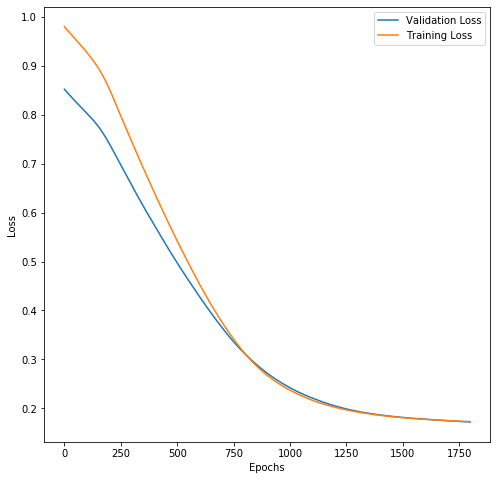

In [35]:
plot_loss(history)

# Task 7: Predictions

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

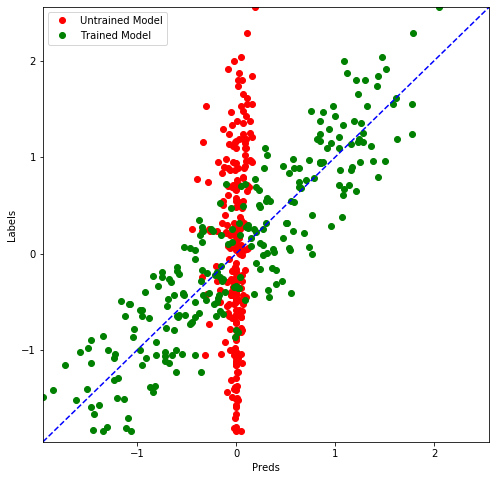

In [36]:
preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

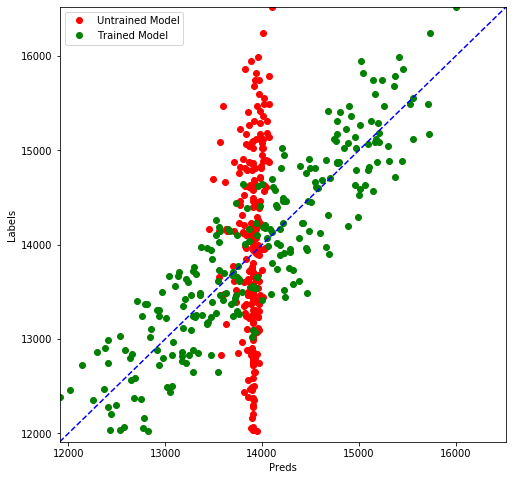

In [37]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)